In [0]:
#import necessery libraries into the session
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image


import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization

In [0]:
#Explore the image size data available in directory
SampleImage=cv2.imread('/dbfs/mnt/blobStorage_1/casting_512x512/casting_512x512/def_front/cast_def_0_100.jpeg',cv2.IMREAD_GRAYSCALE).shape
print('Image sample size in directory', SampleImage)

Image sample size in directory (512, 512)

## Get Image data to Dataframe

In [0]:
#Directory Name
dir='/mnt/blobStorage_1/casting_512x512/casting_512x512'

#Function to Process images and Create Dataframe
def process_images(directory):

    files=dbutils.fs.ls(directory)

    jpeg_files=["/dbfs"+file.path.replace("dbfs:","") for file in files if file.name.endswith('.jpeg')]

    img_flat_data= np.array([cv2.imread(f,cv2.IMREAD_GRAYSCALE).flatten() for f in jpeg_files])

    df_flat = pd.DataFrame(img_flat_data)

    return df_flat


#Process the 'def_images
df_f=process_images(dir+'/def_front/')

#Process the 'ok_images
df_p=process_images(dir+'/ok_front/')

# Define resonse lables: 0 for Fail and 1 for pass
df_f['Y']=0
df_p['Y']=1

#Combine two dataframe
df=pd.concat([df_f,df_p], axis=0)
df.index=range(df.shape[0])

#Display the shape of combined dataframe
print(df.shape)

(1300, 262145)

##Display the Defective Parts

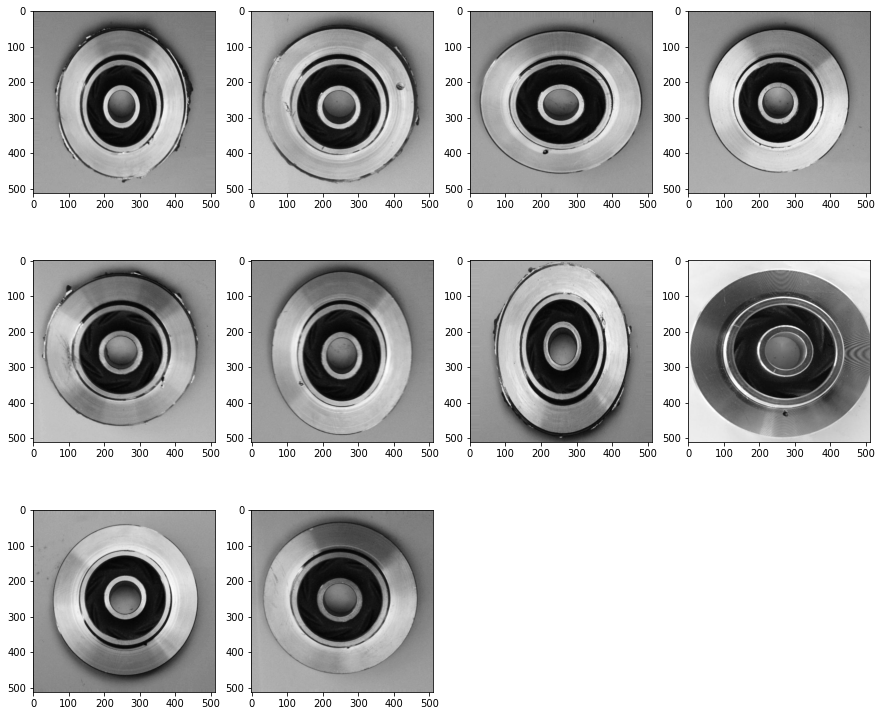

In [0]:
#Display the defective parts with the Matplotlib
plt.figure(figsize=(15,13))
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.imshow(df_f.drop(['Y'], axis=1).iloc[i:i+1].values.reshape(512,512), cmap='gray')

##Display the Pass Parts

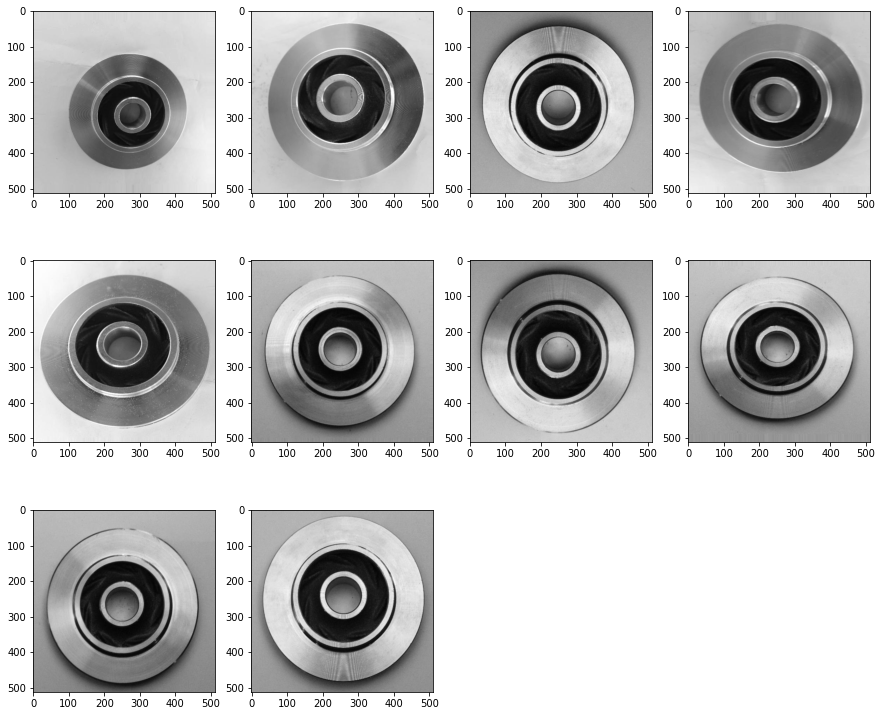

In [0]:
#Display the Okey parts with the Matplotlib
plt.figure(figsize=(15,13))
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.imshow(df_p.drop(['Y'], axis=1).iloc[i:i+1].values.reshape(512,512), cmap='gray')

##Splits data to Train and Test

In [0]:
#Extract features (X) and target (Y) 
X = df.drop(labels='Y', axis=1)
Y=df[['Y']].values

#Reshape the features into (Samples, height, width) format
X = X.values.reshape(X.shape[0],512,512,1)

#Split the data into traning and testing sets
Xtrain, Xtest, ytrain, ytest=train_test_split(X,Y,test_size=0.30,random_state=101)

In [0]:
# Define the model function
def build_model(hp):
    model = Sequential()

    # First CNN layer with adjustable number of filters (hp.Choice)
    model.add(tf.keras.layers.Conv2D(filters=hp.Choice('FirstlayerUnits', values=[16, 32, 64]),
                                     kernel_size=(3, 3),
                                     activation='relu',
                                     input_shape=(512, 512, 1)))  # Input shape of the data
    model.add(tf.keras.layers.MaxPool2D(2, 2))  # Max pooling layer for down-sampling

    # Tune the number of CNN layers based on hp.Int('num_layers')
    for i in range(hp.Int('num_layers', min_value=1, max_value=5)):
        model.add(tf.keras.layers.Conv2D(filters=hp.Int('units_' + str(i),
                                                        min_value=32,
                                                        max_value=512,
                                                        step=32),  # Adjustable number of filters
                                        kernel_size=(3, 3),
                                        activation='relu'))
        model.add(tf.keras.layers.MaxPool2D(2, 2))  # Max pooling layer for down-sampling

    # Flatten the output for fully connected layers
    model.add(tf.keras.layers.Flatten())

    # Fully connected layer with adjustable number of units (hp.Choice)
    model.add(tf.keras.layers.Dense(units=hp.Choice('units', values=[64, 128])))

    # Output layer with one unit and sigmoid activation for binary classification
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

    # Set the learning rate for the optimizer based on hp.Choice
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Compile the model with the chosen optimizer, loss function, and metrics
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [0]:
# Create a RandomSearch tuner
tuner = RandomSearch(
    build_model,                # Function that builds the model
    objective='val_accuracy',  # Objective to optimize (in this case, maximize validation accuracy)
    max_trials=10,             # Number of different hyperparameter combinations to try
    directory='my_dir',       # Directory to store the search results
    project_name='my_project'  # Name of the project
)

# Perform hyperparameter tuning
tuner.search(x=Xtrain, y=ytrain,
             epochs=5,             # Number of training epochs for each model configuration
             validation_data=(Xtest, ytest))

Search: Running Trial #1

Value |Best Value So Far |Hyperparameter
32 |32 |FirstlayerUnits
5 |5 |num_layers
32 |32 |units_0
128 |128 |units
0.001 |0.001 |learning_rate

Epoch 1/5
 1/29 [>.............................] - ETA: 2:03 - loss: 0.8666 - accuracy: 0.6250 2/29 [=>............................] - ETA: 4s - loss: 24.7266 - accuracy: 0.4844  3/29 [==>...........................] - ETA: 4s - loss: 18.8216 - accuracy: 0.5312 4/29 [===>..........................] - ETA: 3s - loss: 14.4075 - accuracy: 0.5625 5/29 [====>.........................] - ETA: 3s - loss: 11.7738 - accuracy: 0.5625 6/29 [=====>........................] - ETA: 3s - loss: 10.1206 - accuracy: 0.5365WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0548s vs `on_train_batch_end` time: 0.0753s). Check your callbacks.
 7/29 [======>.......................] - ETA: 3s - loss: 8.7736 - accuracy: 0.5357  8/29 [=======>......................] - ETA: 3s - loss: 7.8438 - accuracy: 0.5234 9/29 [========>.....................] - ETA: 2s - loss: 7.0566 - accuracy: 0.517410/29 [=========>....................] - ETA: 2s - loss: 6.4790 - accuracy: 0.506311/29 [==========>...................] - ETA: 2s - loss: 5.9776 - accuracy: 0.500012/29 [===========>..................] - ETA: 2s - loss: 5.5245 - accuracy: 0.520813/29 [============>.................] - ETA: 2s - loss: 5.1439 - accuracy: 0.543314/29 [=============>................] - ETA: 2s - loss: 4.8555 - accuracy: 0.553615/29 [==============>...............] - ETA: 1s - loss: 4.5918 - accuracy: 0.560416/29 [===============>..............] - ETA: 1s - loss: 4.3378 - accuracy: 0.568417/29 [================>.............] - ETA: 1s - loss: 4.1271 - accuracy: 0.562518/29 [=================>............] - ETA: 1s - loss: 3.9427 - accuracy: 0.555619/29 [==================>...........] - ETA: 1s - loss: 3.7698 - accuracy: 0.560920/29 [===================>..........] - ETA: 1s - loss: 3.6218 - accuracy: 0.564121/29 [====================>.........] - ETA: 1s - loss: 3.4952 - accuracy: 0.562522/29 [=====================>........] - ETA: 0s - loss: 3.3668 - accuracy: 0.5611

In [0]:
# Print a summary of the hyperparameter search results.
tuner.results_summary()

Results summary
Results in my_dir_/my_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
FirstlayerUnits: 16
num_layers: 5
units_0: 256
units: 64
learning_rate: 0.0001
units_1: 192
units_2: 480
units_3: 416
units_4: 384
Score: 0.843589723110199

Trial 00 summary
Hyperparameters:
FirstlayerUnits: 32
num_layers: 5
units_0: 32
units: 128
learning_rate: 0.001
units_1: 32
units_2: 32
units_3: 32
units_4: 32
Score: 0.8358974456787109

Trial 09 summary
Hyperparameters:
FirstlayerUnits: 64
num_layers: 5
units_0: 352
units: 128
learning_rate: 0.001
units_1: 416
units_2: 128
units_3: 96
units_4: 32
Score: 0.7102563977241516

Trial 06 summary
Hyperparameters:
FirstlayerUnits: 64
num_layers: 5
units_0: 352
units: 128
learning_rate: 0.01
units_1: 288
units_2: 224
units_3: 416
units_4: 128
Score: 0.6435897350311279

Trial 01 summary
Hyperparameters:
FirstlayerUnits: 16
num_layers: 3
units_0: 32
units: 128
learning_rate: 0.01
units_1: 352
units_2: 416
units_3: 416
units_4: 352
Score: 0.6410256624221802

Trial 02 summary
Hyperparameters:
FirstlayerUnits: 16
num_layers: 5
units_0: 192
units: 128
learning_rate: 0.001
units_1: 32
units_2: 288
units_3: 416
units_4: 32
Score: 0.6410256624221802

Trial 03 summary
Hyperparameters:
FirstlayerUnits: 16
num_layers: 2
units_0: 320
units: 64
learning_rate: 0.001
units_1: 32
units_2: 480
units_3: 352
units_4: 448
Score: 0.6410256624221802

Trial 04 summary
Hyperparameters:
FirstlayerUnits: 16
num_layers: 3
units_0: 384
units: 64
learning_rate: 0.01
units_1: 192
units_2: 32
units_3: 32
units_4: 64
Score: 0.6410256624221802

Trial 05 summary
Hyperparameters:
FirstlayerUnits: 32
num_layers: 2
units_0: 64
units: 64
learning_rate: 0.01
units_1: 160
units_2: 256
units_3: 96
units_4: 512
Score: 0.6410256624221802

Trial 08 summary
Hyperparameters:
FirstlayerUnits: 32
num_layers: 5
units_0: 32
units: 64
learning_rate: 0.01
units_1: 320
units_2: 448
units_3: 448
units_4: 32
Score: 0.6410256624221802

In [0]:
# Get the last two best models
last_two_best_models = tuner.get_best_models(num_models=2)

# Access the individual models
last_model = last_two_best_models[0]
second_last_model = last_two_best_models[1]


print('----------------------------Last Model------------------------')
print(last_model.summary())
print('--------------------------------------------------------------')

print('----------------------------second_last_model------------------------')
print(second_last_model.summary())
print('--------------------------------------------------------------')


WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer.iter
WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer.beta_1
WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer.beta_2
WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer.decay
WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer.learning_rate
WARNING:tensorflow:A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.
WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer.iter
WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer.beta_1
WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer.beta_2
WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer.decay
WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer.learning_rate
WARNING:tensorflow:A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.
----------------------------Last Model------------------------
Model: "sequential"
_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
conv2d (Conv2D) (None, 510, 510, 16) 160 
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 16) 0 
_________________________________________________________________
conv2d_1 (Conv2D) (None, 253, 253, 256) 37120 
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 256) 0 
_________________________________________________________________
conv2d_2 (Conv2D) (None, 124, 124, 192) 442560 
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 192) 0 
_________________________________________________________________
conv2d_3 (Conv2D) (None, 60, 60, 480) 829920 
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 480) 0 
_________________________________________________________________
conv2d_4 (Conv2D) (None, 28, 28, 416) 1797536 
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 416) 0 
_________________________________________________________________
conv2d_5 (Conv2D) (None, 12, 12, 384) 1438080 
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 384) 0 
_________________________________________________________________
flatten (Flatten) (None, 13824) 0 
_________________________________________________________________
dense (Dense) (None, 64) 884800 
_________________________________________________________________
dense_1 (Dense) (None, 1) 65 
=================================================================
Total params: 5,430,241
Trainable params: 5,430,241
Non-trainable params: 0
_________________________________________________________________
None
--------------------------------------------------------------
----------------------------second_last_model------------------------
Model: "sequential"
_________________________________________________________________
Layer (type) Output Shape Param # 
=======

Trial 08 summary
Hyperparameters:
FirstlayerUnits: 16
num_layers: 4
units_0: 512
units: 64
learning_rate: 0.0001
units_1: 128
units_2: 128
units_3: 224
units_4: 192
Score: 0.8564102649688721

###CNN Model 0

In [0]:
# Create a Sequential model
model_0 = Sequential()

# Convolutional layers
#FirstLayer
model_0.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(512, 512,1)))
model_0.add(tf.keras.layers.MaxPool2D((2, 2)))

#Hidden layer 1
model_0.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_0.add(tf.keras.layers.MaxPool2D((2, 2)))

#Hidden layer 2
model_0.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_0.add(tf.keras.layers.MaxPool2D((2, 2)))

#Hidden layer 3
model_0.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_0.add(tf.keras.layers.MaxPool2D((2, 2)))

#Hidden layer 4
model_0.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_0.add(tf.keras.layers.MaxPool2D((2, 2)))

#Hidden layer 5
model_0.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_0.add(tf.keras.layers.MaxPool2D((2, 2)))

# Flatten the output for fully connected layers
model_0.add(tf.keras.layers.Flatten())

# Fully connected layers
model_0.add(tf.keras.layers.Dense(128, activation='relu'))
model_0.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the model
model_0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

#Fit Model
history_model_0=model_0.fit(Xtrain,ytrain, epochs=50, batch_size=32, validation_data=(Xtest,ytest), callbacks=[early_stopping])

Epoch 1/50
 1/29 [>.............................] - ETA: 17s - loss: 1.0727 - accuracy: 0.4062 2/29 [=>............................] - ETA: 4s - loss: 4.8785 - accuracy: 0.4844  3/29 [==>...........................] - ETA: 4s - loss: 4.8801 - accuracy: 0.4792 4/29 [===>..........................] - ETA: 4s - loss: 4.1686 - accuracy: 0.4766 5/29 [====>.........................] - ETA: 3s - loss: 3.4896 - accuracy: 0.5063 6/29 [=====>........................] - ETA: 3s - loss: 3.0595 - accuracy: 0.5156WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0565s vs `on_train_batch_end` time: 0.1030s). Check your callbacks.
 7/29 [======>.......................] - ETA: 3s - loss: 2.7389 - accuracy: 0.5045 8/29 [=======>......................] - ETA: 3s - loss: 2.4945 - accuracy: 0.5000 9/29 [========>.....................] - ETA: 3s - loss: 2.3219 - accuracy: 0.465310/29 [=========>....................] - ETA: 2s - loss: 2.1453 - accuracy: 0.487511/29 [==========>...................] - ETA: 2s - loss: 2.0053 - accuracy: 0.505712/29 [===========>..................] - ETA: 2s - loss: 1.8970 - accuracy: 0.515613/29 [============>.................] - ETA: 2s - loss: 1.8063 - accuracy: 0.521614/29 [=============>................] - ETA: 2s - loss: 1.7293 - accuracy: 0.517915/29 [==============>...............] - ETA: 2s - loss: 1.6578 - accuracy: 0.520816/29 [===============>..............] - ETA: 1s - loss: 1.6157 - accuracy: 0.509817/29 [================>.............] - ETA: 1s - loss: 1.5616 - accuracy: 0.507418/29 [=================>............] - ETA: 1s - loss: 1.5181 - accuracy: 0.506919/29 [==================>...........] - ETA: 1s - loss: 1.4808 - accuracy: 0.506620/29 [===================>..........] - ETA: 1s - loss: 1.4354 - accuracy: 0.515621/29 [====================>.........] - ETA: 1s - loss: 1.4033 - accuracy: 0.510422/29 [=====================>........] - ETA: 1s - loss: 1.3703 - accuracy: 0.507123/29 [======================>.......] - ETA: 0s - loss: 1.3389 - accuracy: 0.510924/29 [=========

Out[8]:

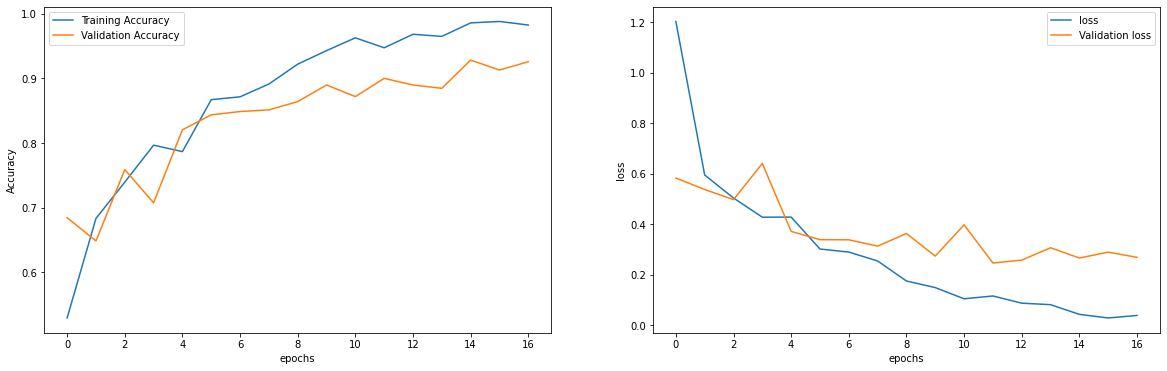

<matplotlib.legend.Legend at 0x7f6f9c4a8b50>

In [0]:
#Plot the Accuracy 
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(history_model_0.history['accuracy'], label='Training Accuracy')
plt.plot(history_model_0.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

#Plot the loss
plt.subplot(1,2,2)
plt.plot(history_model_0.history['loss'], label='loss')
plt.plot(history_model_0.history['val_loss'], label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

##CNN_0 Model + drop out layer

In [0]:
# Create a Sequential model
model_1 = Sequential()

# Convolutional layers
#FirstLayer
model_1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(512, 512,1)))
model_1.add(tf.keras.layers.MaxPool2D((2, 2)))
model_1.add(tf.keras.layers.Dropout(0.1))  # added drop out layer

#Hidden layer 1
model_1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_1.add(tf.keras.layers.MaxPool2D((2, 2)))
model_1.add(tf.keras.layers.Dropout(0.1))    # added drop out layer

#Hidden layer 2
model_1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_1.add(tf.keras.layers.MaxPool2D((2, 2)))
model_1.add(tf.keras.layers.Dropout(0.1))    # added drop out layer

#Hidden layer 3
model_1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_1.add(tf.keras.layers.MaxPool2D((2, 2)))
model_1.add(tf.keras.layers.Dropout(0.1))    # added drop out layer

#Hidden layer 4
model_1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_1.add(tf.keras.layers.MaxPool2D((2, 2)))
model_1.add(tf.keras.layers.Dropout(0.1))    # added drop out layer

#Hidden layer 5
model_1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_1.add(tf.keras.layers.MaxPool2D((2, 2)))
model_1.add(tf.keras.layers.Dropout(0.1))    # added drop out layer

# Flatten the output for fully connected layers
model_1.add(tf.keras.layers.Flatten())

# Fully connected layers
model_1.add(tf.keras.layers.Dense(128, activation='relu'))
model_1.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the model
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')

#Fit Model
history_model_1=model_1.fit(Xtrain,ytrain, epochs=50, batch_size=32, validation_data=(Xtest,ytest), callbacks=[early_stopping])

Epoch 1/50
 1/29 [>.............................] - ETA: 2:36 - loss: 16.8018 - accuracy: 0.5938 2/29 [=>............................] - ETA: 4s - loss: 57.3613 - accuracy: 0.5000  3/29 [==>...........................] - ETA: 4s - loss: 47.9205 - accuracy: 0.4479 4/29 [===>..........................] - ETA: 4s - loss: 36.9803 - accuracy: 0.4766 5/29 [====>.........................] - ETA: 3s - loss: 30.3163 - accuracy: 0.4812 6/29 [=====>........................] - ETA: 3s - loss: 26.1585 - accuracy: 0.4688WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0603s vs `on_train_batch_end` time: 0.0813s). Check your callbacks.
 7/29 [======>.......................] - ETA: 3s - loss: 22.7597 - accuracy: 0.4821 8/29 [=======>......................] - ETA: 3s - loss: 20.4676 - accuracy: 0.5000 9/29 [========>.....................] - ETA: 3s - loss: 18.7995 - accuracy: 0.506910/29 [=========>....................] - ETA: 2s - loss: 17.1524 - accuracy: 0.518811/29 [==========>...................] - ETA: 2s - loss: 15.7945 - accuracy: 0.511412/29 [===========>..................] - ETA: 2s - loss: 14.5807 - accuracy: 0.500013/29 [============>.................] - ETA: 2s - loss: 13.5543 - accuracy: 0.490414/29 [=============>................] - ETA: 2s - loss: 12.7045 - accuracy: 0.482115/29 [==============>...............] - ETA: 2s - loss: 11.9223 - accuracy: 0.489616/29 [===============>..............] - ETA: 1s - loss: 11.2134 - accuracy: 0.505917/29 [================>.............] - ETA: 1s - loss: 10.6263 - accuracy: 0.505518/29 [=================>............] - ETA: 1s - loss: 10.0890 - accuracy: 0.512219/29 [==================>...........] - ETA: 1s - loss: 9.6113 - accuracy: 0.5115 20/29 [===================>..........] - ETA: 1s - loss: 9.1743 - accuracy: 0.512521/29 [====================>.........] - ETA: 1s - loss: 8.7794 - accuracy: 0.511922/29 [=====================>........] - ETA: 1s - loss: 8.4155 - accuracy: 0.512823/29 [======================>.......] - ETA: 0s - loss: 8.0774 - accuracy: 0.5217

Out[6]:

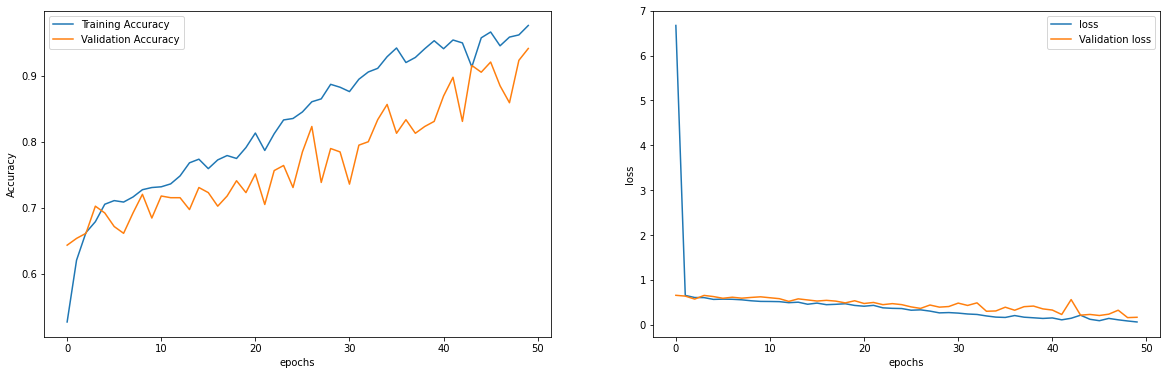

<matplotlib.legend.Legend at 0x7fba9005d8e0>

In [0]:
#Plot the Accuracy 
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(history_model_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_model_1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

#Plot the loss
plt.subplot(1,2,2)
plt.plot(history_model_1.history['loss'], label='loss')
plt.plot(history_model_1.history['val_loss'], label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [0]:
#prediction over the test data and labeling 
y_testpred_model_1=model_1.predict(Xtest)

#assigning the binery labeling as per class
for i in range(len(y_testpred_model_1)):
    if y_testpred_model_1[i]>0.5:
        y_testpred_model_1[i]=1
    else:
        y_testpred_model_1[i]=0

#Confusion matrix and Classification Report
print(confusion_matrix(ytest,y_testpred_model_1))
print(classification_report(ytest,y_testpred_model_1))

[[242 8]
 [ 15 125]]
 precision recall f1-score support

 0 0.94 0.97 0.95 250
 1 0.94 0.89 0.92 140

 accuracy 0.94 390
 macro avg 0.94 0.93 0.94 390
weighted avg 0.94 0.94 0.94 390

# **Trasfer leanirng**

**popular pre-trained models for image classification**


1.   VGG (Visual Geometry Group) models
2.   ResNet (Residual Network) models
3.   Inception models




##VGG16

In [0]:
#Directory Name
dir='/mnt/blobStorage_1/casting_512x512/casting_512x512'

#Function to Process images and Create Dataframe
def process_images_vgg16(directory):

    files=dbutils.fs.ls(directory)

    jpeg_files=["/dbfs"+file.path.replace("dbfs:","") for file in files if file.name.endswith('.jpeg')]


    img_flat_data= np.array([tf.keras.applications.vgg16.preprocess_input(cv2.resize(cv2.imread(f),(224,224))).flatten() for f in jpeg_files])

    df_flat = pd.DataFrame(img_flat_data)

    return df_flat


#Process the 'def_images
df_f_vgg16=process_images_vgg16(dir+'/def_front/')

#Process the 'ok_images
df_p_vgg16=process_images_vgg16(dir+'/ok_front/')

# Define resonse lables: 0 for Fail and 1 for pass
df_f_vgg16['Y']=0
df_p_vgg16['Y']=1

#Combine two dataframe
df_vgg16=pd.concat([df_f_vgg16,df_p_vgg16], axis=0)
df_vgg16.index=range(df_vgg16.shape[0])

#Display the shape of combined dataframe
print(df_vgg16.shape)

#Extract features (X) and target (Y) 
X = df_vgg16.drop(labels='Y', axis=1)
Y=df_vgg16[['Y']].values

#Reshape the features into (Samples, height, width) format
X = X.values.reshape(X.shape[0],224,224,3)

#Split the data into traning and testing sets
Xtrain, Xtest, ytrain, ytest=train_test_split(X,Y,test_size=0.30,random_state=101)

(1300, 150529)

In [0]:
# Base VGG16 model
base_vgg16 = tf.keras.applications.vgg16.VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

x = base_vgg16.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Add your own output layer for binary classification
predictions_vgg16 = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_vgg16 = tf.keras.models.Model(inputs=base_vgg16.input, outputs=predictions_vgg16)

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history_tmodel_1 = model_vgg16.fit(x=Xtrain, y=ytrain, batch_size=32, epochs=50, validation_data=(Xtest, ytest), callbacks=[early_stopping])

Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
 16384/58889256 [..............................] - ETA: 1:31 49152/58889256 [..............................] - ETA: 3:43 81920/58889256 [..............................] - ETA: 4:07 114688/58889256 [..............................] - ETA: 3:24 163840/58889256 [..............................] - ETA: 2:48 196608/58889256 [..............................] - ETA: 2:36 245760/58889256 [..............................] - ETA: 2:19 319488/58889256 [..............................] - ETA: 1:56 409600/58889256 [..............................] - ETA: 1:38 516096/58889256 [..............................] - ETA: 1:23 638976/58889256 [..............................] - ETA: 1:11 835584/58889256 [..............................] - ETA: 58s  1081344/58889256 [..............................] - ETA: 47s 1376256/58889256 [..............................] - ETA: 39s 1769472/58889256 [..............................] - ETA: 32s 2318336/58889256 [>.............................] - ETA: 25s 2990080/58889256 [>.............................] - ETA: 20s 3858432/58889256 [>.............................] - ETA: 16s 4980736/58889256 [=>............................] - ETA: 12s 6389760/58889256 [==>...........................] - ETA: 10s 8044544/58889256 [===>..........................] - ETA: 8s  9322496/58889256 [===>..........................] - ETA: 7s10616832/58889256 [====>.........................] - ETA: 6s12337152/58889256 [=====>........................] - ETA: 5s14041088/58889256 [======>.......................] - ETA: 4s14729216/58889256 [======>.......................] - ETA: 4s16662528/58889256 [=======>......................] - ETA: 4s18022400/58889256 [========>.....................] - ETA: 3s19046400/58889256 [========>.....................] - ETA: 3s20979712/58889256 [=========>....................] - ETA: 3s22282240/58889256 [==========>...................] - ETA: 3s23969792/58889256 [===========>..................] - ETA: 2s

Out[17]:

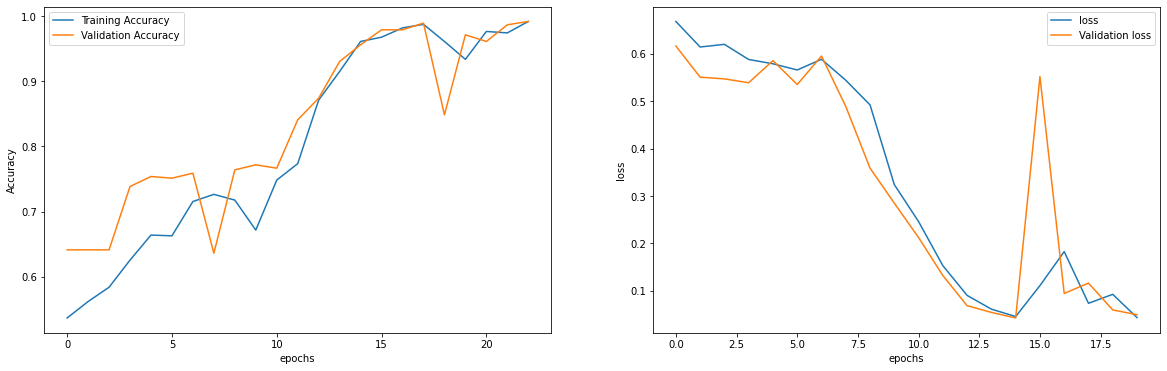

<matplotlib.legend.Legend at 0x7ff9e16c9640>

In [0]:
#define figure window area
#Plot the Accuracy 
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(history_tmodel_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_tmodel_1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

#Plot the loss
plt.subplot(1,2,2)
plt.plot(history_tmodel_1.history['loss'][3:], label='loss')
plt.plot(history_tmodel_1.history['val_loss'][3:], label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [0]:
#prediction over the test data and labeling 
y_testpred_vgg16=model_vgg16.predict(Xtest)

#assigning the binery labeling as per class
for i in range(len(y_testpred_vgg16)):
    if y_testpred_vgg16[i]>0.5:
        y_testpred_vgg16[i]=1
    else:
        y_testpred_vgg16[i]=0

#Confusion matrix and Classification Report
print(confusion_matrix(ytest,y_testpred_vgg16))
print(classification_report(ytest,y_testpred_vgg16))

[[248 2]
 [ 1 139]]
 precision recall f1-score support

 0 1.00 0.99 0.99 250
 1 0.99 0.99 0.99 140

 accuracy 0.99 390
 macro avg 0.99 0.99 0.99 390
weighted avg 0.99 0.99 0.99 390


##Vgg19

In [0]:
#Directory Name
dir='/mnt/blobStorage_1/casting_512x512/casting_512x512'

#Function to Process images and Create Dataframe
def process_images_vgg19(directory):

    files=dbutils.fs.ls(directory)

    jpeg_files=["/dbfs"+file.path.replace("dbfs:","") for file in files if file.name.endswith('.jpeg')]

    img_flat_data= np.array([tf.keras.applications.vgg19.preprocess_input(cv2.resize(cv2.imread(f),(224,224))).flatten() for f in jpeg_files])

    df_flat = pd.DataFrame(img_flat_data)

    return df_flat


#Process the 'def_images
df_f_vgg19=process_images_vgg19(dir+'/def_front/')

#Process the 'ok_images
df_p_vgg19=process_images_vgg19(dir+'/ok_front/')

# Define resonse lables: 0 for Fail and 1 for pass
df_f_vgg19['Y']=0
df_p_vgg19['Y']=1

#Combine two dataframe
df_vgg19=pd.concat([df_f_vgg19,df_p_vgg19], axis=0)
df_vgg19.index=range(df_vgg19.shape[0])

#Display the shape of combined dataframe
print(df_vgg19.shape)

#Extract features (X) and target (Y) 
X = df_vgg19.drop(labels='Y', axis=1)
Y=df_vgg19[['Y']].values

#Reshape the features into (Samples, height, width) format
X = X.values.reshape(X.shape[0],224,224,3)

#Split the data into traning and testing sets
Xtrain, Xtest, ytrain, ytest=train_test_split(X,Y,test_size=0.30,random_state=101)

(1300, 150529)

In [0]:
# Base VGG19 model
base_vgg19 = tf.keras.applications.vgg19.VGG19(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

x = base_vgg19.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Add your own output layer for binary classification
predictions_vgg19 = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_vgg19 = tf.keras.models.Model(inputs=base_vgg19.input, outputs=predictions_vgg19)

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')

model_vgg19.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history_tmodel_3 = model_vgg19.fit(x=Xtrain, y=ytrain, batch_size=32, epochs=50, validation_data=(Xtest, ytest), callbacks=[early_stopping])

Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5
 16384/80134624 [..............................] - ETA: 4:36 32768/80134624 [..............................] - ETA: 5:31 49152/80134624 [..............................] - ETA: 6:15 81920/80134624 [..............................] - ETA: 6:18 131072/80134624 [..............................] - ETA: 4:35 180224/80134624 [..............................] - ETA: 3:49 229376/80134624 [..............................] - ETA: 3:21 294912/80134624 [..............................] - ETA: 2:53 409600/80134624 [..............................] - ETA: 2:15 524288/80134624 [..............................] - ETA: 1:53 655360/80134624 [..............................] - ETA: 1:36 851968/80134624 [..............................] - ETA: 1:19 1114112/80134624 [..............................] - ETA: 1:03 1441792/80134624 [..............................] - ETA: 51s  1851392/80134624 [..............................] - ETA: 42s 2400256/80134624 [..............................] - ETA: 34s 3137536/80134624 [>.............................] - ETA: 27s 4022272/80134624 [>.............................] - ETA: 21s 5177344/80134624 [>.............................] - ETA: 17s 6275072/80134624 [=>............................] - ETA: 14s 8044544/80134624 [==>...........................] - ETA: 11s 9404416/80134624 [==>...........................] - ETA: 10s10387456/80134624 [==>...........................] - ETA: 9s 12337152/80134624 [===>..........................] - ETA: 8s13664256/80134624 [====>.........................] - ETA: 7s14884864/80134624 [====>.........................] - ETA: 6s16629760/80134624 [=====>........................] - ETA: 6s17924096/80134624 [=====>........................] - ETA: 5s19013632/80134624 [======>.......................] - ETA: 5s20955136/80134624 [======>.......................] - ETA: 5s22282240/80134624 [=======>......................] - ETA: 4s23445504/80134624 [=======>......................] - 

Out[8]:

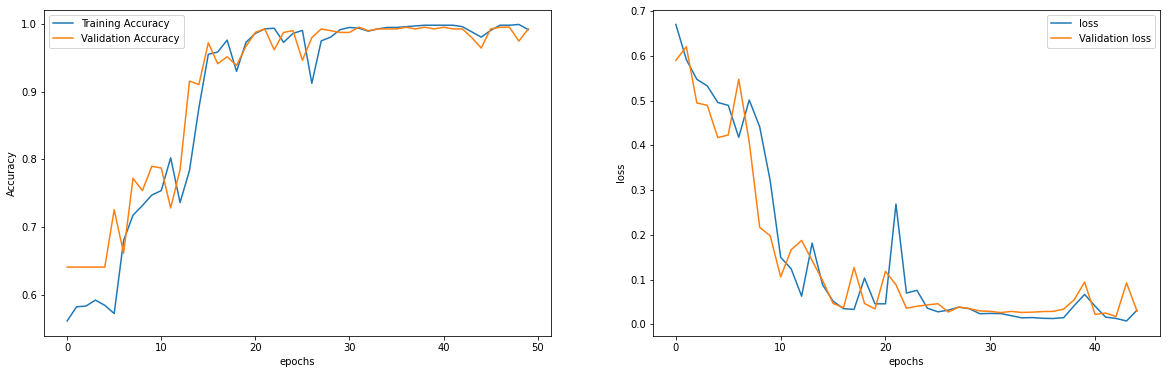

<matplotlib.legend.Legend at 0x7f85460a7d30>

In [0]:
#define figure window area
#Plot the Accuracy 
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(history_tmodel_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_tmodel_3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

#Plot the loss
plt.subplot(1,2,2)
plt.plot(history_tmodel_3.history['loss'][5:], label='loss')
plt.plot(history_tmodel_3.history['val_loss'][5:], label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [0]:
#prediction over the test data and labeling 
y_testpred_vgg19=model_vgg19.predict(Xtest)

#assigning the binery labeling as per class
for i in range(len(y_testpred_vgg19)):
    if y_testpred_vgg19[i]>0.5:
        y_testpred_vgg19[i]=1
    else:
        y_testpred_vgg19[i]=0

#Confusion matrix and Classification Report
print(confusion_matrix(ytest,y_testpred_vgg19))
print(classification_report(ytest,y_testpred_vgg19))

[[248 2]
 [ 1 139]]
 precision recall f1-score support

 0 1.00 0.99 0.99 250
 1 0.99 0.99 0.99 140

 accuracy 0.99 390
 macro avg 0.99 0.99 0.99 390
weighted avg 0.99 0.99 0.99 390

# RestNet50

In [0]:
#Directory Name
dir='/mnt/blobStorage_1/casting_512x512/casting_512x512'

#Function to Process images and Create Dataframe
def process_images(directory):

    files=dbutils.fs.ls(directory)

    jpeg_files=["/dbfs"+file.path.replace("dbfs:","") for file in files if file.name.endswith('.jpeg')]

    img_flat_data= np.array([cv2.resize(cv2.imread(f),(224,224)).flatten() for f in jpeg_files])

    df_flat = pd.DataFrame(img_flat_data)

    return df_flat


#Process the 'def_images
df_f=process_images(dir+'/def_front/')

#Process the 'ok_images
df_p=process_images(dir+'/ok_front/')

# Define resonse lables: 0 for Fail and 1 for pass
df_f['Y']=0
df_p['Y']=1

#Combine two dataframe
df=pd.concat([df_f,df_p], axis=0)
df.index=range(df.shape[0])

#Display the shape of combined dataframe
print(df.shape)

#Extract features (X) and target (Y) 
X = df.drop(labels='Y', axis=1)
Y=df[['Y']].values

#Reshape the features into (Samples, height, width) format
X = X.values.reshape(X.shape[0],224,224,3)

#Split the data into traning and testing sets
Xtrain, Xtest, ytrain, ytest=train_test_split(X,Y,test_size=0.30,random_state=101)


# Load ResNet-50 model without top (fully connected) layers
base_model_rn50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224, 3))

# Add custom layers on top of the pre-trained ResNet-50
x = base_model_rn50.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

predictions_rn50 = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the final model
model_rn50 = tf.keras.models.Model(inputs=base_model_rn50.input, outputs=predictions_rn50)

# Compile the model
model_rn50.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

history_1_rn50=model_rn50.fit(x=Xtrain, y=ytrain, epochs=50, batch_size=32, validation_data=(Xtest, ytest), callbacks=[early_stopping])



(1300, 150529)
Epoch 1/50
 1/29 [>.............................] - ETA: 1:52 - loss: 0.8238 - accuracy: 0.3438 2/29 [=>............................] - ETA: 10s - loss: 0.7301 - accuracy: 0.5156  3/29 [==>...........................] - ETA: 15s - loss: 0.9349 - accuracy: 0.5000 4/29 [===>..........................] - ETA: 12s - loss: 0.9085 - accuracy: 0.5547 5/29 [====>.........................] - ETA: 10s - loss: 0.8022 - accuracy: 0.6187 6/29 [=====>........................] - ETA: 9s - loss: 0.8970 - accuracy: 0.6250 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1033s vs `on_train_batch_end` time: 0.2788s). Check your callbacks.
 7/29 [======>.......................] - ETA: 8s - loss: 0.8568 - accuracy: 0.6250 8/29 [=======>......................] - ETA: 7s - loss: 0.8270 - accuracy: 0.6250 9/29 [========>.....................] - ETA: 6s - loss: 0.7906 - accuracy: 0.656210/29 [=========>....................] - ETA: 6s - loss: 0.7527 - accuracy: 0.675011/29 [==========>...................] - ETA: 5s - loss: 0.7168 - accuracy: 0.693212/29 [===========>..................] - ETA: 5s - loss: 0.6809 - accuracy: 0.713513/29 [============>.................] - ETA: 5s - loss: 0.6457 - accuracy: 0.733214/29 [=============>................] - ETA: 4s - loss: 0.6136 - accuracy: 0.750015/29 [==============>...............] - ETA: 4s - loss: 0.5839 - accuracy: 0.764616/29 [===============>..............] - ETA: 4s - loss: 0.5628 - accuracy: 0.773417/29 [================>.............] - ETA: 3s - loss: 0.5546 - accuracy: 0.777618/29 [=================>............] - ETA: 3s - loss: 0.5367 - accuracy: 0.784719/29 [==================>...........] - ETA: 3s - loss: 0.5324 - accuracy: 0.789520/29 [===================>..........] - ETA: 2s - loss: 0.5147 - accuracy: 0.796921/29 [====================>.........] - ETA: 2s - loss: 0.5000 - accuracy: 0.802122/29 [=====================>........] - ETA: 2s - loss: 0.4860 - accuracy: 0.806823/29 [======================>.......] - ETA: 1s - loss: 0.4749 - accuracy: 0.8111

Out[5]:

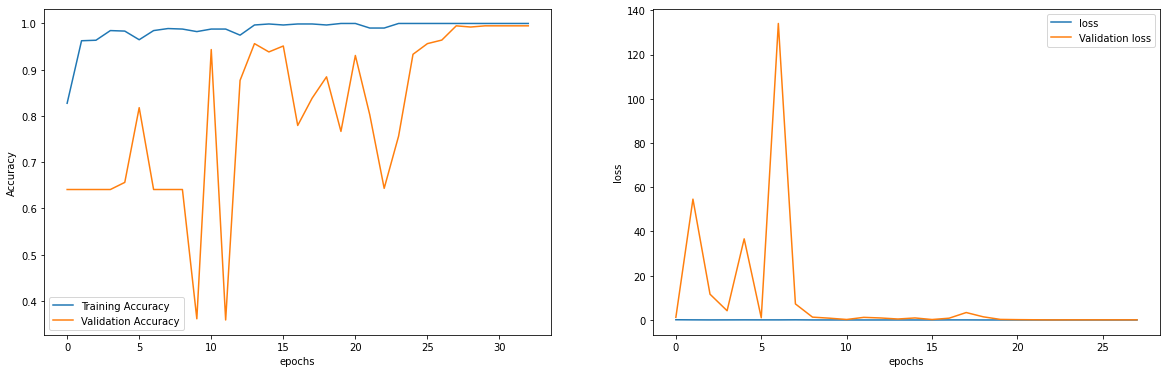

<matplotlib.legend.Legend at 0x7f0d60e652b0>

In [0]:
#define figure window area
#Plot the Accuracy 
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(history_1_rn50.history['accuracy'], label='Training Accuracy')
plt.plot(history_1_rn50.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

#Plot the loss
plt.subplot(1,2,2)
plt.plot(history_1_rn50.history['loss'][5:], label='loss')
plt.plot(history_1_rn50.history['val_loss'][5:], label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [0]:
#Directory Name
dir='/mnt/blobStorage_1/casting_512x512/casting_512x512'

#Function to Process images and Create Dataframe
def process_images(directory):

    files=dbutils.fs.ls(directory)

    jpeg_files=["/dbfs"+file.path.replace("dbfs:","") for file in files if file.name.endswith('.jpeg')]

    img_flat_data= np.array([cv2.resize(cv2.imread(f),(224,224)).flatten() for f in jpeg_files])

    df_flat = pd.DataFrame(img_flat_data)

    return df_flat


#Process the 'def_images
df_f=process_images(dir+'/def_front/')

#Process the 'ok_images
df_p=process_images(dir+'/ok_front/')

# Define resonse lables: 0 for Fail and 1 for pass
df_f['Y']=0
df_p['Y']=1

#Combine two dataframe
df=pd.concat([df_f,df_p], axis=0)
df.index=range(df.shape[0])

#Display the shape of combined dataframe
print(df.shape)

#Extract features (X) and target (Y) 
X = df.drop(labels='Y', axis=1)
Y=df[['Y']].values

#Reshape the features into (Samples, height, width) format
X = X.values.reshape(X.shape[0],224,224,3)

#Split the data into traning and testing sets
Xtrain, Xtest, ytrain, ytest=train_test_split(X,Y,test_size=0.30,random_state=101)


# Load ResNet-50 model without top (fully connected) layers
base_model_rn50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224, 3))

# Add custom layers on top of the pre-trained ResNet-50
x = base_model_rn50.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)

predictions_rn50 = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the final model
model_rn50 = tf.keras.models.Model(inputs=base_model_rn50.input, outputs=predictions_rn50)

# Compile the model
model_rn50.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

history_2_rn50=model_rn50.fit(x=Xtrain, y=ytrain, epochs=50, batch_size=32, validation_data=(Xtest, ytest), callbacks=[early_stopping])



(1300, 150529)
Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
 16384/94765736 [..............................] - ETA: 5:04 49152/94765736 [..............................] - ETA: 6:28 81920/94765736 [..............................] - ETA: 6:52 114688/94765736 [..............................] - ETA: 5:47 147456/94765736 [..............................] - ETA: 5:09 180224/94765736 [..............................] - ETA: 4:45 229376/94765736 [..............................] - ETA: 4:09 294912/94765736 [..............................] - ETA: 3:31 393216/94765736 [..............................] - ETA: 2:51 491520/94765736 [..............................] - ETA: 2:27 622592/94765736 [..............................] - ETA: 2:04 819200/94765736 [..............................] - ETA: 1:40 1064960/94765736 [..............................] - ETA: 1:21 1343488/94765736 [..............................] - ETA: 1:07 1703936/94765736 [..............................] - ETA: 56s  2203648/94765736 [..............................] - ETA: 45s 2842624/94765736 [..............................] - ETA: 36s 3629056/94765736 [>.............................] - ETA: 29s 4685824/94765736 [>.............................] - ETA: 23s 5947392/94765736 [>.............................] - ETA: 19s 7733248/94765736 [=>............................] - ETA: 14s 8896512/94765736 [=>............................] - ETA: 13s10256384/94765736 [==>...........................] - ETA: 11s11894784/94765736 [==>...........................] - ETA: 10s13172736/94765736 [===>..........................] - ETA: 9s 14901248/94765736 [===>..........................] - ETA: 8s16187392/94765736 [====>.........................] - ETA: 8s17661952/94765736 [====>.........................] - ETA: 7s19218432/94765736 [=====>........................] - ETA: 6s20709376/94765736 [=====>........................] - ETA: 6s22241280/94765736 [======>.......................] - ETA: 6s23642112/94765736 [======>.

Out[3]:

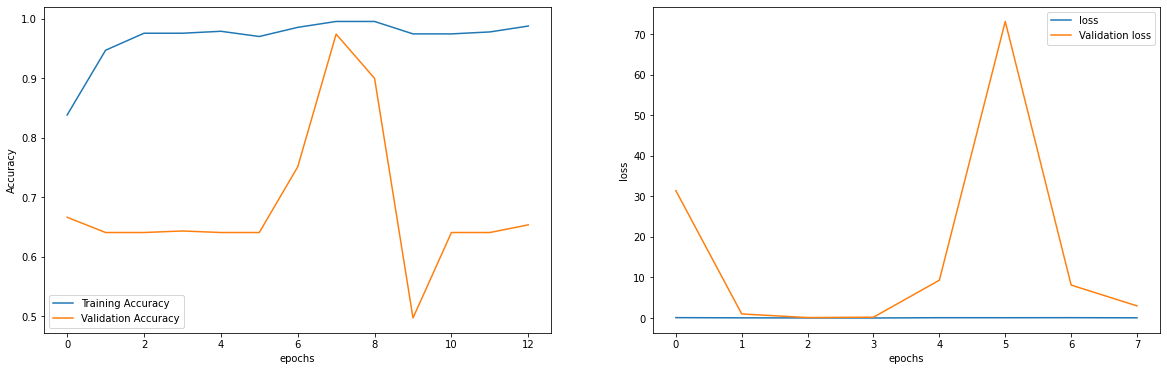

<matplotlib.legend.Legend at 0x7f985033c160>

In [0]:
#define figure window area
#Plot the Accuracy 
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(history_2_rn50.history['accuracy'], label='Training Accuracy')
plt.plot(history_2_rn50.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

#Plot the loss
plt.subplot(1,2,2)
plt.plot(history_2_rn50.history['loss'][5:], label='loss')
plt.plot(history_2_rn50.history['val_loss'][5:], label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

##InceptionV3

In [0]:
# Directory Name
dir = '/mnt/blobStorage_1/casting_512x512/casting_512x512'

# Function to Process images and Create DataFrame
def process_images(directory):
    files = dbutils.fs.ls(directory)
    jpeg_files = ["/dbfs" + file.path.replace("dbfs:", "") for file in files if file.name.endswith('.jpeg')]
    img_flat_data = np.array([cv2.resize(cv2.imread(f), (224, 224)).flatten() for f in jpeg_files])
    df_flat = pd.DataFrame(img_flat_data)
    return df_flat

# Process the 'def_images'
df_f = process_images(dir + '/def_front/')

# Process the 'ok_images'
df_p = process_images(dir + '/ok_front/')

# Define response labels: 0 for Fail and 1 for Pass
df_f['Y'] = 0
df_p['Y'] = 1

# Combine two dataframes
df = pd.concat([df_f, df_p], axis=0)
df.index = range(df.shape[0])

# Display the shape of the combined dataframe
print(df.shape)

# Extract features (X) and target (Y)
X = df.drop(labels='Y', axis=1)
Y = df[['Y']].values

# Reshape the features into (Samples, height, width) format
X = X.values.reshape(X.shape[0], 224, 224, 3)

# Split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.30, random_state=101)

# Load InceptionV3 model without top (fully connected) layers
base_model_inception = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the pre-trained InceptionV3
x = base_model_inception.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

predictions_inception = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the final model
model_inception = tf.keras.models.Model(inputs=base_model_inception.input, outputs=predictions_inception)

# Compile the model
model_inception.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Train the model
history_1_inception = model_inception.fit(x=Xtrain, y=ytrain, epochs=50, batch_size=32, validation_data=(Xtest, ytest), callbacks=[early_stopping])

(1300, 150529)
Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
 16384/87910968 [..............................] - ETA: 6s 49152/87910968 [..............................] - ETA: 4:10 81920/87910968 [..............................] - ETA: 4:59 393216/87910968 [..............................] - ETA: 1:13 688128/87910968 [..............................] - ETA: 48s  884736/87910968 [..............................] - ETA: 42s 1196032/87910968 [..............................] - ETA: 35s 1556480/87910968 [..............................] - ETA: 29s 2236416/87910968 [..............................] - ETA: 22s 2957312/87910968 [>.............................] - ETA: 18s 3743744/87910968 [>.............................] - ETA: 15s 4898816/87910968 [>.............................] - ETA: 12s 6488064/87910968 [=>............................] - ETA: 9s  8192000/87910968 [=>............................] - ETA: 8s 9486336/87910968 [==>...........................] - ETA: 7s11108352/87910968 [==>...........................] - ETA: 6s12713984/87910968 [===>..........................] - ETA: 5s13721600/87910968 [===>..........................] - ETA: 5s16547840/87910968 [====>.........................] - ETA: 4s17825792/87910968 [=====>........................] - ETA: 4s18309120/87910968 [=====>........................] - ETA: 4s21086208/87910968 [======>.......................] - ETA: 4s22413312/87910968 [======>.......................] - ETA: 3s23461888/87910968 [=======>......................] - ETA: 3s25755648/87910968 [=======>......................] - ETA: 3s27082752/87910968 [========>.....................] - ETA: 3s27820032/87910968 [========>.....................] - ETA: 3s29564928/87910968 [=========>....................] - ETA: 3s31604736/87910968 [=========>....................] - ETA: 2s32473088/87910968 [==========>...................] - ETA: 2s34258944/87910968 [==========>...................] - ETA: 2s36028416/87910968 [===========>..................] - ETA: 2

Out[3]:

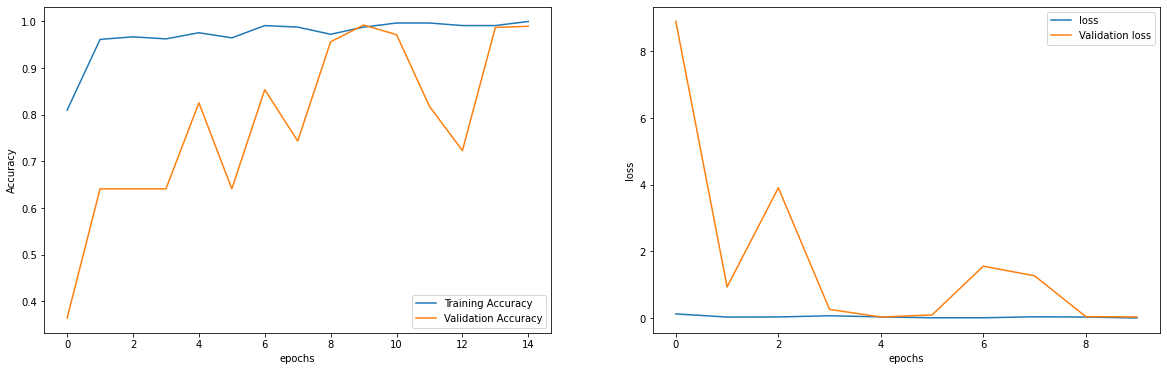

<matplotlib.legend.Legend at 0x7f58c4049730>

In [0]:
#define figure window area
#Plot the Accuracy 
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(history_1_inception.history['accuracy'], label='Training Accuracy')
plt.plot(history_1_inception.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

#Plot the loss
plt.subplot(1,2,2)
plt.plot(history_1_inception.history['loss'][5:], label='loss')
plt.plot(history_1_inception.history['val_loss'][5:], label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [0]:
#prediction over the test data and labeling 
y_testpred_inception=model_inception.predict(Xtest)

#assigning the binery labeling as per class
for i in range(len(y_testpred_inception)):
    if y_testpred_inception[i]>0.5:
        y_testpred_inception[i]=1
    else:
        y_testpred_inception[i]=0

#Confusion matrix and Classification Report
print(confusion_matrix(ytest,y_testpred_inception))
print(classification_report(ytest,y_testpred_inception))

[[246 4]
 [ 0 140]]
 precision recall f1-score support

 0 1.00 0.98 0.99 250
 1 0.97 1.00 0.99 140

 accuracy 0.99 390
 macro avg 0.99 0.99 0.99 390
weighted avg 0.99 0.99 0.99 390

##Summery

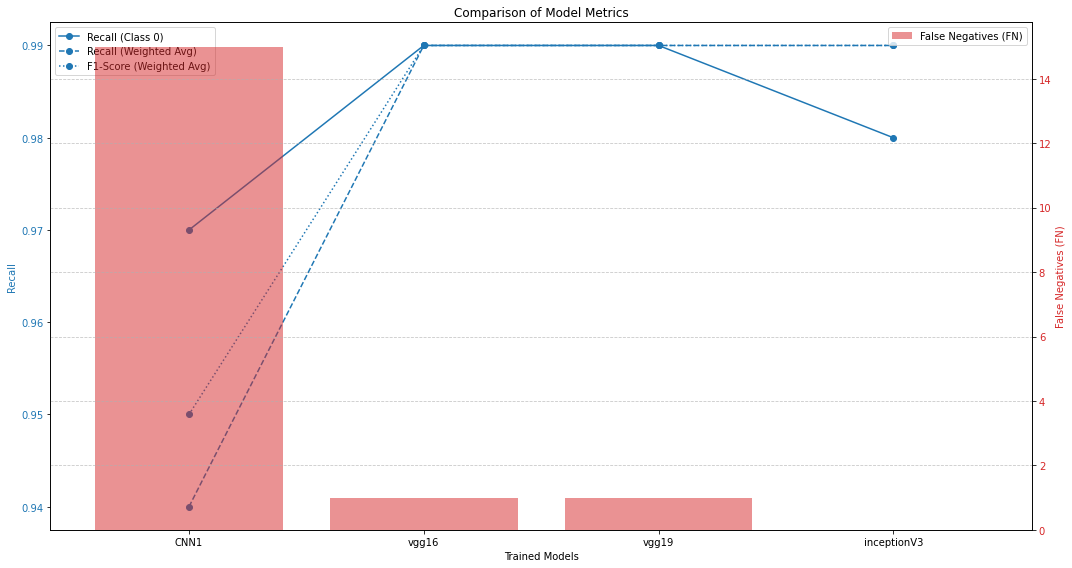

In [0]:
# Data
trained_models = ['CNN1', 'vgg16', 'vgg19', 'inceptionV3']
recall_0 = [0.97, 0.99, 0.99, 0.98]
FN = [15, 1, 1, 0]
recall_weighted_avg = [0.94, 0.99, 0.99, 0.99]
f1score_weighted_avg = [0.95, 0.99, 0.99, 0.99]

# Create two subplots with shared x-axis
fig, ax1 = plt.subplots(figsize=(15, 8))

# Line plot for recall_0, recall_weighted_avg, and f1score_weighted_avg
ax1.set_xlabel('Trained Models')
ax1.set_ylabel('Recall', color='tab:blue')
ax1.plot(trained_models, recall_0, marker='o', label='Recall (Class 0)', color='tab:blue')
ax1.plot(trained_models, recall_weighted_avg, marker='o', label='Recall (Weighted Avg)', linestyle='--', color='tab:blue')
ax1.plot(trained_models, f1score_weighted_avg, marker='o', label='F1-Score (Weighted Avg)', linestyle=':', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Create a second y-axis for the bar plot (FN)
ax2 = ax1.twinx()
ax2.set_ylabel('False Negatives (FN)', color='tab:red')
ax2.bar(trained_models, FN, alpha=0.5, color='tab:red', label='False Negatives (FN)')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')


# Title and grid
plt.title('Comparison of Model Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
#plt.show()
